In [1]:
import pandas as pd
import numpy as np
import pickle
import time
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [3]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    num_centroids = max(word_centroid_map.values()) + 1
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

In [4]:
model = Word2Vec.load("caches/300features_40minwords_10context")

In [5]:
word_vectors = model.syn0

In [6]:
num_clusters = word_vectors.shape[0] // 5

In [7]:
num_clusters

3298

In [9]:
start = time.time()
print("Running K means")
kmeans_clustering = KMeans(n_clusters=num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
end = time.time()
elapsed = end - start
print("Time taken for K Means Clustering: %f seconds." % elapsed)

Running K means
Time taken for K Means Clustering: 516.773352 seconds.


In [11]:
with open('caches/idx.pkl', 'wb') as f:
    pickle.dump(idx, f)

In [12]:
word_centroid_map = dict(zip(model.index2word, idx))

In [13]:
raw_train = pd.read_csv('data/labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)

In [14]:
from clean import review2wordlist

In [15]:
clean_train_reviews = []
for review in raw_train["review"]:
    clean_train_reviews.append(review2wordlist(review, no_stopwords=True))

In [16]:
train_set_features = np.zeros((raw_train["review"].size, num_clusters), dtype="float32")

In [17]:
counter = 0
for review in clean_train_reviews:
    train_set_features[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [18]:
train_set_labels = raw_train["sentiment"]

In [19]:
rf = RandomForestClassifier(n_estimators=100)
gnb = GaussianNB()
lr = LogisticRegression()

In [20]:
from roc_plot import roc_plot_nocv

start training and validating...
RandomForestClassifier done
GaussianNB done
LogisticRegression done


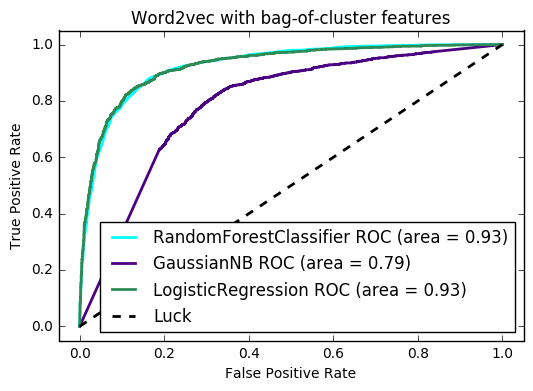

In [21]:
aucs = roc_plot_nocv(classifiers=[rf, gnb, lr], X=train_set_features, y=train_set_labels, plot_title="Word2vec with bag-of-cluster features")